# Diving into DALI: Exploring NVIDIA's Image Augmentation Library

<img src="images/The Persistence of Memory - Dali.jpg" alt="The Persistence of Memory - Dali" align="left" width="500" />

*Salvador Dalí. The Persistence of Memory. 1931. Image credit: [The Museum of Modern Art](https://www.moma.org/collection/works/79018)

Deep learning image augmentation pipelines typically offer either speed or flexibility, but never both at the same time. Computationally efficient, production-ready computer vision pipelines tend to be written in C++ and require developers to manually specify all nuts and bolts of image transform algorithms to such an extent that these pipelines aren't terribly amenable to further on-the-fly tweaking. On the other end of the spectrum, popular Python libraries like [Pillow](https://pillow.readthedocs.io/en/stable/) offer high-level APIs that let practitioners choose from near unlimited combinations of tweaks that can be applied to a vast repository of image transform algorithms. Unfortunately, this freedom carries with it the cost of a steep slowdown in processing time.

The [DALI Library](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/getting%20started.html) attempts to give practitioners the best of both worlds. Its image transform algorithms are themselves written in C++ code that squeezes every last drop of performance out of NVIDIA GPU chips, such that image transforms can be performed in parallel on a per-batch basis, across however many GPUs a user has access to. The C++ source code is designed to be called from inside a user-friendly and supposedly flexible Python API, which users can use to create image transform pipelines that play nice with both the PyTorch and TensorFlow frameworks.

In an attempt to ascertain whether DALI indeed delivers both the speed and flexibility it advertises, I spent the better part of one week running a series of my own experiments with the library. Spoiler alert: while DALI absolutely brings the speed, flexibility is still somewhat lacking.

### DALI's Promise
Nonetheless, I believe that taking the time to get acquainted with DALI is absolutely worthwhile. The benefits of doing image augmentation on the GPU are self-evident, and my DALI image pipeline ran several times faster than any other comparable image pipeline I've ever written.

Moreover, given that I just completed part II of the fast.ai deep learning [course](https://course.fast.ai/) earlier this spring, I wanted to see if I could build a DALI pipeline that seamlessly meshed with the reworked, [new and improved version](https://github.com/jamesdellinger/fastai_deep_learning_course_part2_v3) of the fastai library that we built together from scratch as part of our coursework. According to core fastai developer [Sylvain Gugger](https://www.fast.ai/about/#sylvain), the upcoming official version 2 of the fastai library [will contain several of the paradigms](https://forums.fast.ai/t/fastai-v2-roadmap/46661) that we built during our class, such as training loops with a far more flexible callback integration.

Over the next few paragraphs I'll walk through the ABCs of building DALI pipelines and connecting them to fastai's new style of training loop. As we journey, you'll also see just how fast DALI runs (it's really impressive), as well as one *really weird* workaround I came up with in an attempt to get around one striking shortcoming of the DALI libary.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from exports.nb_10 import *

In [3]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, feed_ndarray

### Setting the Stage
My DALI augmentation pipeline includes the random crop & resize, flip, perspective warp, and rotation transforms that I learned to [implement from scratch](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true) in this year's fast.ai part II. To set a baseline and gauge whether each DALI transform helps improve results, I created a simple, four layer CNN model whose task was to perform image classification using the [Imagenette dataset](https://github.com/fastai/imagenette). Imagenette was created by [Jeremy Howard](https://www.fast.ai/about/#jeremy) to be a much slimmed-down version of ImageNet that allows practitioners to get a rough feel for how their model would perform if trained on ImageNet, without actually having to train ImageNet from scratch. I like to use Imagenette to perform quick sanity checks during early iterations on prototypes, and it's become an indispensable part of my experiments.

In [4]:
# Path to the Imagenette dataset
path = datasets.untar_data(imagenette_url)

Image inputs are normalized using the Imagenette means and standard deviations that I calculated back in [Notebook 08](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true).

In [5]:
from torch import Tensor

bs=64 # batch size
imagenette_means = Tensor([0.4879, 0.4740, 0.4307])
imagenette_std_devs = Tensor([0.2814, 0.2831, 0.3079])

### How to Build a DALI Pipeline

The backbone of all DALI pipelines is a Python [class called `Pipeline`](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/getting%20started.html#Pipeline). I found that it was straightforward to create specialized pipelines for my training and validation data that both inherit from DALI's pipeline class.

Two methods must be defined when writing your own pipeline class: `__init__()` and `define_graph()`. The init method is the place to specify the hyperparameters of each and every transform operation you wish to call. In addition to augmentations like image rotations and flips, these operations will also include initial image loading, as well as any image resizing and normalizing, tensor reshaping, and data type casting.

`define_graph()` is the place where you specify *the order* in which you want your pipeline's image transforms to be executed. This method is also where you will want to call a DALI random number generator so that you can pass it to any image transform operation that supports randomly generated augmentations. `define_graph()` ultimately returns a tuple containing your augmented images and their labels. To illustrate how all these pieces come together, here's how I used DALI's `ops.Rotate` function to add randomly generated image rotations to my training pipeline:

1. In the pipeline's `__init__()` method I created variables for the rotation operation, `ops.Rotate`, as well as for two random number generators. The first random number generator, `ops.Uniform`, will produce a list as long as my batch size. This list will contain floats randomly chosen from a uniform distribution that spans a particular range, and these floats represent angles (in degrees), by which `ops.Rotate` will rotate the batch's images. The second random number generator, `ops.CoinFlip` creates a list containing ones and zeros that is also as long as the batch size. The ones appear with a frequency of 7.5%, and passing this list to the rotation transform will ensure that any image in a batch will have a 7.5% chance of getting rotated:
```python
self.rotate = ops.Rotate(device='gpu', interp_type=types.INTERP_NN)
self.rotate_range = ops.Uniform(range = (-7, 7))
self.rotate_coin = ops.CoinFlip(probability=0.075)
```

2. The `define_graph()` method is where I call the `ops.Uniform` and `ops.CoinFlip` random number generators to create fresh sets of random numbers for each batch. I then call `ops.Rotate` and pass the two lists of random numbers to its `angle` and `mask` attributes, respectively:
```python
prob_rotate = self.rotate_coin()
angle_range = self.rotate_range()
...
images = self.rotate(images, angle=angle_range, mask=prob_rotate)
```

DALI will now rotate about 7.5% of the images in each training batch by an angle between -7 and 7 degrees. All image rotations will happen at the same time.

[`ops.Rotate`](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#rotate) is, to my mind, the ideal DALI transform operation in that it supports rotating each image by a *randomly chosen* angle. Supporting random parameters should be table stakes for any image augmentation operation. Unfortunately, as I'll detail soon enough, this *isn't true* for DALI's [`ops.WarpAffine`](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.WarpAffine) perspective warp transform operation.

Once train and validation pipeline classes are completely defined, all that's left to do is build the pipelines and create the train and validation data loaders. I demonstrate this just below, but before that, just below is the complete code for my training and validation set pipeline classes.

### Generating random affine transforms for image perspective warps

Dali's [`ops.WarpAffine`](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#warpaffine) method has a `matrix` argument that accepts a list of six float values that specify an affine transform matrix.

Here's a quick refresher on affine transforms:

A 2-dimensional affine transformation has the very recognizable form $$y = Ax + b$$ where:
* A is a 2x2 matrix
* b is a vector with 2 coordinates

This kind of affine transform is often represented as the following 3x3 matrix:

$$
\begin{bmatrix} 
A[0,0] &  A[0,1] & b[0] \\
A[1,0] &  A[1,1] & b[1] \\
 0    &   0   &   1
\end{bmatrix}
$$

Now in order to properly pass an affine transform matrix to `ops.WarpAffine`, we place the $A$ and $b$ values into a list in the following order:
```
[A[0,0], A[0,1], b[0], A[1,0], A[1,1], b[1]]
```

In the cell below I've written a helper function to generate an affine transform that can be used to apply a perspective warp to an image. But do I want to apply just any kind of warp? Not really. I want be sure that however I warp the image, the contents of the image don't appear squished or stretched -- it should just look like the image is tilting toward or away from me. I can do this using logic somewhat similar to what was implemented in the [image augmentation notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true#Perspective-Warping) from part II of the 2019 fast.ai deep learning course: 
> If the upper-left corner x and y coordinates are shifted by certain  magnitudes, the lower-left and upper-right x,y coordinates should be shifted by the same magnitudes, but in the other direction.

My algorithm below follows these steps:
1. Take a triangle represented by three sets of coordinates from the original image -- I'll use the orignal image's upper-left, lower-left, and upper-right corners.
2. Specify where I want the coordinates of that triangle to be shifted in the warped image. 
3. Compute the affine transform that would relocate the coordinates specified in step 1. to the new locations specified in step 2.

#### `get_affine_tfm()`

In [6]:
import cv2
import numpy as np

def get_affine_tfm(im_size, mag):
    
    x_mag = uniform(-mag, mag)
    y_mag = uniform(-mag, mag)
    
    src_pts = (np.array([[0,0], [0,1], [1,0]])*im_size).astype(np.float32)
    dest_pts = (np.array([[-x_mag, -y_mag], [x_mag, 1+y_mag], [1+x_mag, y_mag]])*im_size).astype(np.float32)
    affine_tfm = cv2.getAffineTransform(src_pts, dest_pts)
    return FloatTensor(affine_tfm).view(6).tolist()  

In [7]:
get_affine_tfm(128, 0.1)

[0.9795135259628296,
 -0.02048650197684765,
 1.3111361265182495,
 -0.05597070977091789,
 0.9440293312072754,
 3.582125425338745]

### Train and Val Pipelines

In [8]:
im_size = 128

class ImagenetteTrainPipeline(Pipeline):
    def __init__(self, batch_size=bs, num_threads=8, device_id=0):
        super(ImagenetteTrainPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root = path/'train', random_shuffle=True)
        
        # Randomly crop and resize
        self.decode = ops.nvJPEGDecoderRandomCrop(device='mixed', output_type=types.RGB,
                                                  random_area=[0.08,1.0], 
                                                  random_aspect_ratio=[0.75,1.333333], 
                                                  num_attempts=100)
        self.resize = ops.Resize(device='gpu', resize_x=im_size, resize_y=im_size,
                                 interp_type=types.INTERP_NN)
        
        # Will flip vertically with prob of 0.1
        self.vert_flip = ops.Flip(device='gpu', horizontal=0, interp_type=types.INTERP_NN)
        self.vert_coin = ops.CoinFlip(probability=0.1)
        
        # My workaround for Dali not supporting random affine transforms: 
        # a "synthetic random" warp affine transform.
        self.num_warp_tfms = 7
        self.affine_tfms = [get_affine_tfm(im_size, 0.1) for i in range(self.num_warp_tfms)]
        self.warp_tfms = [ops.WarpAffine(device='gpu', matrix=i, interp_type=types.INTERP_NN) for i in self.affine_tfms]
        self.warp_prob = ops.CoinFlip(probability=0.025)
        # TODO: self.warp_prob() should actually be called below in define_graph(). 
        # Calling it up here in the __init__ method means that the same warp affines 
        # will be applied to images at the *same* indices in every mini-batch.
        self.warp_probs = [self.warp_prob() for i in range(self.num_warp_tfms)]
        
        # Rotate within a narrow range with probability of 0.075
        self.rotate = ops.Rotate(device='gpu', interp_type=types.INTERP_NN)
        self.rotate_range = ops.Uniform(range = (-7, 7))
        self.rotate_coin = ops.CoinFlip(probability=0.075)
        
        # Flip horizontally with prob of 0.5, then convert tensor format from 
        # NHWC to NCHW and normalize.
        self.cmnp = ops.CropMirrorNormalize(device='gpu',
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(im_size, im_size),
                                            image_type=types.RGB,
                                            mean=listify(imagenette_means*255),
                                            std=listify(imagenette_std_devs*255))
        self.mirror_coin  = ops.CoinFlip(probability=0.5)
        
    def define_graph(self):
        # Generate new random numbers for each mini-batch
        prob_vert_flip = self.vert_coin()
        prob_rotate = self.rotate_coin()
        prob_mirror = self.mirror_coin()
        angle_range = self.rotate_range()

        # Perform pipeline operations in the order they appear below:
        self.jpegs, self.labels = self.input(name='r')
        images = self.decode(self.jpegs)
        images = self.resize(images)
        images = self.vert_flip(images, vertical=prob_vert_flip) # Specify prob_vert_flip here 
        
        for i, tfm in enumerate(self.warp_tfms):
            images = tfm(images, mask=self.warp_probs[i])
        images = self.rotate(images, angle=angle_range, mask=prob_rotate)

        images = self.cmnp(images, mirror=prob_mirror)        
        return (images, self.labels)
    
class ImagenetteValPipeline(Pipeline):
    def __init__(self, batch_size=bs, num_threads=8, device_id=0):
        super(ImagenetteValPipeline, self).__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(file_root = path/'val')
        self.decode = ops.nvJPEGDecoder(device='mixed', output_type=types.RGB)
        # Not possible to center crop with DALI, so I use the entire image.
        self.resize = ops.Resize(device = 'gpu', resize_x=im_size, resize_y=im_size, 
                                 interp_type=types.INTERP_NN)
        
        # Convert tensor format from NHWC to NCHW and normalize
        self.normperm = ops.NormalizePermute(device="gpu",
                                       height=im_size,
                                       width=im_size,
                                       output_dtype=types.FLOAT,
                                       image_type=types.RGB,
                                       mean=listify(imagenette_means*255),
                                       std=listify(imagenette_std_devs*255))
        
    def define_graph(self):
        self.jpegs, self.labels = self.input(name='r')
        images = self.decode(self.jpegs)
        images = self.resize(images)
        images = self.normperm(images)
        return (images, self.labels)

### Building DALI Data loaders

It takes me just three lines of code to build a data loader that works with PyTorch. 

```python
pipe = ImagenetteTrainPipeline()
pipe.build()
train_dl = DALIClassificationIterator(pipe, pipe.epoch_size('r'), stop_at_epoch=True)
```

In [9]:
pipe = ImagenetteTrainPipeline()
pipe.build()
images, labels = pipe.run()
images.as_tensor().shape(), labels.as_tensor().shape()

([64, 3, 128, 128], [64, 1])

### Dali Pipeline Speed Test

Every DALI pipeline object has a `run()` function that will grab a batch of images, send it through the pipeline, and return the transformed images and their labels. Timing this function enabled me to measure just how fast DALI could fly. 

Note that I ran my speed test using an AWS [p2.xlarge](https://aws.amazon.com/ec2/instance-types/p2/) compute instance that has a single GPU, and mini-batches containing 64 images. I found that the final version of my Imagenette training pipeline, which contains eleven operations, runs in just over 40 ms. Moreover, this 40 ms includes the time it takes to load the initial batch's images. Subsequent batches should run faster because DALI is able to load each subsequent batch ahead of time. 

As I added in more transforms, even upwards of twenty consecutive warp affine transforms at one point, the duration never exceeded much higher than 50 ms. (Why did I feel the need to have so many warp affine operations? I'll get to that shortly.)

At any rate, a duration of 40 ms per mini-batch works out to around 625 µs per image for *all* eleven operations that are in the pipeline. As a basis for comparison, in our fast.ai image augmentation [lesson notebook](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true#Time-Budget), we saw that the main choke point of using Pillow for image transforms was the 5 ms it took for Pillow to load a single image.

In the very same notebook we also used PyTorch JIT [to implement](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true#JIT-version-of-rotate_batch()) an image rotation algorithm that, similar to DALI, transforms batches on the GPU. It ran around 4.3 ms per batch. Assuming that a JIT implementation of any transform would take the same duration (possibly a stretch), a quick back-of-the-envelope calculation would seem to indicate that JIT performance is not much worse than DALI (4.3 x 11 = 47.3 ms). However, the beauty of DALI is that while it took *twelve lines of code* to define the script that carries out our JIT rotation transform, DALI lets us get all the same functionality and speed with just a single function call!

In [10]:
%timeit -n 100 t_ims, t_lbls = pipe.run()

41.7 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Display a training mini-batch

In [11]:
t_dali_dl = DALIClassificationIterator(pipe, pipe.epoch_size('r'), stop_at_epoch=True)
next_batch = next(t_dali_dl)[0]['data']
next_batch.size()

torch.Size([64, 3, 128, 128])

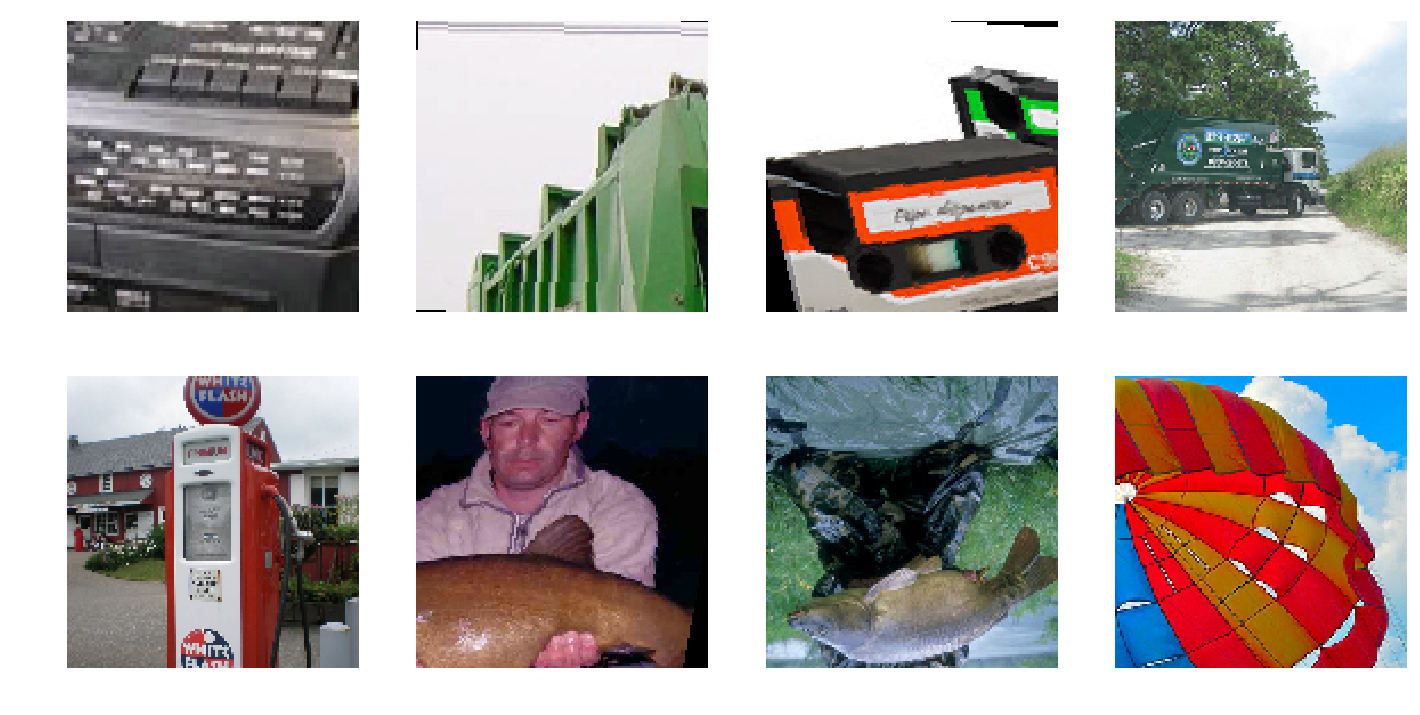

In [12]:
# Format the batch so we can display using matplotlib.
def denorm_batch(normed_batch):
    means = imagenette_means.view(1,3,1,1).cuda()
    std_devs = imagenette_std_devs.view(1,3,1,1).cuda()
    return torch.clamp((normed_batch * std_devs + means).permute(0,2,3,1), min=0)

show_batch(denorm_batch(next_batch), rows=2)

### Initialize training and validation DALI iterators (data loaders)

In [13]:
train_dl = DALIClassificationIterator(pipe, pipe.epoch_size('r'), stop_at_epoch=True)

In [14]:
pipe = ImagenetteValPipeline()
pipe.build()
valid_dl = DALIClassificationIterator(pipe, pipe.epoch_size('r'), stop_at_epoch=True)

### Three tricks to get the new fastai to work with DALI data loaders

I'd like to take a brief detour to share with folks going through the 2019 fast.ai deep learning part II [course](https://course.fast.ai/index.html), three tweaks I added to the codebase so that I could get DALI's data loaders to work seamlessly with the new-and-improved fastai [training loop](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true#Getting-rid-of-the-Runner-class) that is implemented as part of this course. [This notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Make-the-Learner-class-compatible-with-Dali-dataloaders) has a working version of a training loop that includes all the following modifications:

1. Modify the `Learner` class so that it properly indexes into the tensors returned by DALI data loaders to grab the images and labels for each batch. Images and labels are contained under `'data'` and `'labels'` keys, respectively:
```python
xb = to_float_tensor(batch[0]['data'])
yb = batch[0]['label'].squeeze().cuda().long()
```
    Also reset DALI train and val data loaders after each epoch:
```python
self.data.train_dl.reset()
self.data.valid_dl.reset()
```

2. Change the `AvgStats` callback so that it returns `self.tot_loss` (and not `self.tot_loss.item()`):
```python
def all_stats(self): return [self.tot_loss] + self.tot_mets
```

3. Finally, cap the maximum value that the hyperparameter schedule builder, `combine_scheds()`, uses to track the current iteration's position relative to the training cycle's length. While this value should always be below 1.0, when using DALI there were times when its value at *the beginning* of the final iteration would be 1.0 or just greater (e.g. 1.0000000000000022). This results in an IndexError, as the scheduler is forced to index into a schedule phase that actually doesn't exist!

Note that I highly recommend the [latest](https://course.fast.ai/index.html) fast.ai part II to anyone who is on their journey toward becoming a deep learning practitioner and researcher: it's no exaggeration to say that when you finish going through the course notebooks, you will have ability and confidence that you can implement *anything* from scratch all on your own!

#### 1. Make the `Learner` class compatible with Dali data loaders
NVIDIA's DALI team wrote their own training loop that uses Dali data loaders and then trains a ResNet50 model on ImageNet. That [example](https://github.com/NVIDIA/DALI/blob/666ce55ec27783f36f2b7a39076793d955d4ad0f/docs/examples/pytorch/resnet50/main.py) was invaluable in helping me to identify how to modify the `Learner` class in order to make it compatible with Dali.

In [15]:
class DaliLearner(Learner):
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=3e-4, 
                 splitter=param_getter, callback_funcs=None):
        super(DaliLearner, self).__init__(model, data, loss_func, opt_func=sgd_opt, lr=3e-4, 
                 splitter=param_getter, callback_funcs=callback_funcs)
            
    def all_batches(self):
        self.iters = int(self.dl._size/bs)
        try:
            for i, batch in enumerate(self.dl): 
                # Modification #1: Extract image and label tensors from 
                # Dali iterators (data loaders)
                xb = to_float_tensor(batch[0]['data'])
                yb = batch[0]['label'].squeeze().cuda().long()
                self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
    
    def fit(self, epochs, callback_funcs=None, reset_opt=False):
        self.add_callbacks(callback_funcs)
        if reset_opt or not self.opt: 
            self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
        
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()
                
                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
                # Modification #2: Reset Dali train and val iterators 
                # (data loaders) at epoch's end.
                self.data.train_dl.reset()
                self.data.valid_dl.reset()
        
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')
            self.remove_callbacks(callback_funcs)
            
def get_dali_learner(n_outs, data, lr=3e-4, layer=conv_layer, loss_func=F.cross_entropy,
                callback_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, n_outs, layer, **kwargs)
    init_cnn(model)
    return DaliLearner(model, data, loss_func, lr, layer, opt_func,
                       callback_funcs=callback_funcs)

#### 2. Make the `AvgStats` class compatible with Dali data loaders

In [16]:
class DaliAvgStats(AvgStats):
    def __init__(self, metrics, in_train):
        super(DaliAvgStats, self).__init__(metrics, in_train)
        
    # Modification: Leave self.tot_loss as a Cuda Tensor, since 
    # we're doing everything on the GPU. 
    # Note that orignal implementation of AvgStats used: self.tot_loss.item()
    @property
    def all_stats(self): return [self.tot_loss] + self.tot_mets
    
class DaliAvgStatsCallback(AvgStatsCallback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = DaliAvgStats(metrics,in_train=True), DaliAvgStats(metrics,in_train=False)

#### 3. Finally, fix the hyperparam scheduler

I found that my training loop would occasionally break at the final iteration of the final epoch. The error message I saw was:

```python
~/fastai_docs/dev_course/dl2/exports/nb_05.py in _inner(pos)
     37     def _inner(pos):
     38         idx = (pos >= pcts).nonzero().max()
---> 39         actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
     40         return scheds[idx](actual_pos)
     41     return _inner

IndexError: index 3 is out of bounds for dimension 0 with size 3
```

This lead me to examine the `combine_scheds()` method that was created back in [Notebook 05](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/05_anneal_my_reimplementation.ipynb?flush_cache=true#combine_scheds()). We use `combine_scheds()` to define hyper parameter schedules, such as one-cycle cosine learning rate warmup and annealing. It turned out that the value for the `pos` variable at the beginning of the final iteration of the final epoch is sometimes 1.0 or greater (sometimes it's less). When it's 1.0 or higher, this breaks the logic later on down in `combine_scheds()`, as it gets forced to index one position further in the `pcts` list than we'd anticipated. To prevent this, I capped the maximum value of `pos` and `0.9999999`.

In [17]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        # Using Dali data loaders, pos at beginning of final iteration of 
        # final epoch is sometimes slightly above 1.0 (e.g. 1.0000000000000022).
        # Unfortunately the logic below only works if pos is always less than 1.0
        # at beginning of final iteration.
        #
        # Modification: cap maximum pos value at 0.9999999 to prevent this 
        # unexpected numerical instability.
        pos = min(1-1e-7, pos)
        idx = (pos >= pcts).nonzero().max() # Get index of most-recently completed phase.
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

### Train a simple CNN

In [20]:
min_lr=3e-1
n_outs = [64, 64, 128, 256] 
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(min_lr, 3*min_lr, min_lr))
scheduler = ParamScheduler('lr', phases)
callback_funcs = [partial(DaliAvgStatsCallback, accuracy),
                  CudaCallback,
                  Recorder]
data = DataBunch(train_dl, valid_dl, 3, 10)
learn = get_dali_learner(n_outs, data, layer=conv_layer, callback_funcs=callback_funcs)

In [21]:
learn.fit(8, scheduler)

['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy', 'time']
['0', '1.895819', '0.337211', '2.429746', '0.330000', '00:15']
['1', '1.636598', '0.447417', '2.799575', '0.234000', '00:16']
['2', '1.474476', '0.507290', '1.589068', '0.496000', '00:16']
['3', '1.333716', '0.564216', '1.419040', '0.550000', '00:16']
['4', '1.228488', '0.597255', '1.017867', '0.674000', '00:15']
['5', '1.168154', '0.619901', '1.559534', '0.512000', '00:15']
['6', '1.084979', '0.645106', '0.884512', '0.718000', '00:15']
['7', '1.034656', '0.663254', '0.908206', '0.720000', '00:15']


### Run 10 independent training runs

In [22]:
for i in range(10):
    min_lr=3e-1
    n_outs = [64, 64, 128, 256] 
    phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(min_lr, 3*min_lr, min_lr))
    scheduler = ParamScheduler('lr', phases)
    callback_funcs = [partial(DaliAvgStatsCallback, accuracy),
                      CudaCallback,
                      Recorder]
    data = DataBunch(train_dl, valid_dl, 3, 10)
    learn = get_dali_learner(n_outs, data, layer=conv_layer, callback_funcs=callback_funcs)
    
    learn.fit(8, scheduler)

['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy', 'time']
['0', '1.903252', '0.327672', '1.881599', '0.356000', '00:15']
['1', '1.641446', '0.441368', '2.001688', '0.392000', '00:15']
['2', '1.460489', '0.515356', '1.404899', '0.562000', '00:15']
['3', '1.337661', '0.557003', '1.531008', '0.512000', '00:16']
['4', '1.222545', '0.595393', '1.292349', '0.568000', '00:15']
['5', '1.164153', '0.619358', '1.158262', '0.606000', '00:15']
['6', '1.090362', '0.641616', '1.012236', '0.674000', '00:15']
['7', '1.037324', '0.655576', '0.893488', '0.734000', '00:15']
['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy', 'time']
['0', '1.919156', '0.322786', '1.869435', '0.380000', '00:15']
['1', '1.656038', '0.438964', '2.416688', '0.346000', '00:15']
['2', '1.461003', '0.511633', '1.326631', '0.566000', '00:15']
['3', '1.335952', '0.555607', '1.178318', '0.608000', '00:15']
['4', '1.218848', '0.602606', '1.268802', '0.566000', '00:15']
['5', '1.160984',

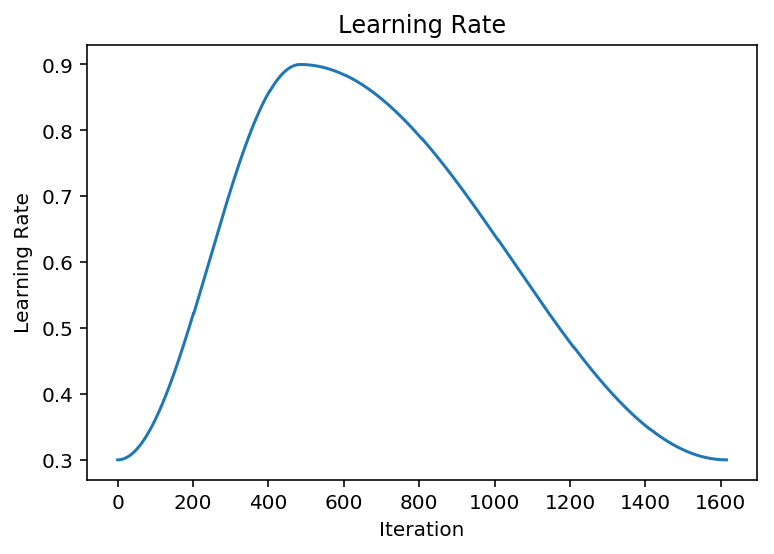

In [94]:
learn.recorder.plot_lr()

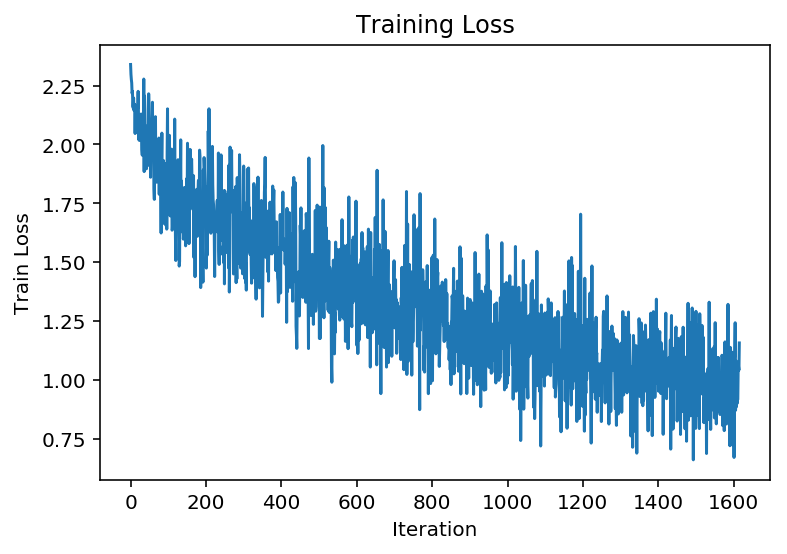

In [95]:
learn.recorder.plot_loss()

## "Lab Notebook" for my DALI Transform Explorations:
Once my DALI data loader and new fastai training loop were working in perfect harmony, I set for myself the goal of choosing parameters for each of the DALI image transforms that I planned to include (perspective warp, flips, and rotation). I wanted each transform to actually improve my model's performance over the following baseline:

**My Global Baseline** Random crop resize + 50% chance of horizontal mirror, 8 epochs, one-cycle cosine warmup/annealing, min lr=3e-1, max_lr=9e-1, image size 128px: Valid Accuracy: `72.4%`

### "Synthetic Random"  Warp Affine Transform experiments:
As a workaround to DALI's [lack of support](https://github.com/NVIDIA/DALI/issues/552) for randomized perspective warp transforms, I wondered if nonetheless it might be possible to implement DALI's non-randomized perspective warp transform in such a way that it would *seem* to behave as if it truly were random. In order to be deemed successful, this strategy would of course need to bring with it the kind of improvement in model performance that one would expect a truly random perspective warp augmentation to offer. My strategy was as follows:

**"Synthetic random" warp transform**:
1. Write [a function](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Generating-random-affine-transforms-for-image-perspective-warps) that generates random affine transformations, formatted so that the transform can be passed to DALI's `ops.WarpAffine` [operation](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.WarpAffine). My algorithm ensures that a randomly generated affine transform will tilt an image's perspective, but won't unnaturally squish or stretch the contents of the image.
2. Add somewhere between two and twenty DALI `ops.WarpAffine` operations to my pipeline. (I performed experiments to determine the right amount and found that seven worked best.)
3. Generate a unique affine transformation for each DALI `ops.WarpAffine` operation that I include in my pipeline.
4. Apply each of the pipeline's warp affine transforms to a particular image with a probability somewhere between 0.3 and 0.025. (I performed experiments to determine the best probability and found that 0.025 worked best.)

My intuition was that with an adequately chosen number of warp affine operations, balanced with a suitable probability that each operation would be applied, I could:
1. Maximize the *variety* of perspective warp transforms applied to a mini-batch's images.
2. Adequately minimize the chance that a single image would have two or more warp transforms applied to it during each mini-batch.

#### DALI warp affine experiment 1: choosing *where* in the pipeline to place my "synthetic random" warp affine transform, and at *what resolution*
I realized that there were also two other things I could adjust:
1. Whether I apply warp affines *before* or *after* I randomly crop and resize training inputs.
2. Whether or not I want the outputs of the warp affine transforms to have black corners: If I kept images at 128px before and after applying warp transforms, outputs would have black corners. However, if I randomly crop and resize images to 156px, I could then generate an affine transform that will both tilt and crop the image down to 128px. If I do this, output images would have no black corners.

I decided that the following three approaches best encapsulated the possible options. I didn't want to spend too much time on these experiments, so I performed a single training run using each of these three approaches and chose the approach that scored highest.

Approach #1:
* Use my 4-step synthetic randomized warp affine work-around. Placing 5 warp affines in the pipeline, each with 0.1 prob of being executed. I apply these warp affines *after* crop and resize. Image resolution is 128px: 

   Valid Accuracy: `69.0%`
---

Approach #2:
* Same as approach #1, but apply warp affine operations *before* crop and resize: 

   Valid Accuracy: `66.6%` (also ends up adding up to 22sec of train time per epoch)
---

Approach #3:
* Same as approach #1, but generate affine transforms that prevent any black triangles in corners after warp applied by first resizing image inputs to 156px, then generate an affine transform that will tilt and crop the input image to 128px: 

   Valid Accuracy: `67.2%`

**Conclusion:** Based on a comparison of the above three approaches, I decided that I should settle on approach #1. 

#### DALI warp affine experiment 2: find some promising combinations of number of warp affines & probability of application
Now that I knew how and where in my pipeline I'd place my "synthetic random" warp affine, I still had to determine the right balance between variety (the number of warp affine operations I'd actually include) and probability (the chance that any individual warp affine operation would be applied to a given image). 

I decided to make this a two-part grid-search competition. For the first part, which I undertake here in this experiment, I perform several single runs across a wide variety of number warp affines/probability combinations. The top four performing combinations will move onto the final round, which will take place in experiment 3 below.

* 1 warp affine, 0.1 prob of application: Valid Accuracy: `71.6%`
* 2 warp affines, 0.1 prob of application: Valid Accuracy: `71.4%`
* 3 warp affines, 0.1 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 4 warp affines, 0.1 prob of application: Valid Accuracy: `71.4%`
* 5 warp affines, 0.1 prob of application: Valid Accuracy: `69.0%`
* 6 warp affines, 0.1 prob of application: Valid Accuracy: `72.2%`
* 7 warp affines, 0.1 prob of application: Valid Accuracy: `70.6%`
* 8 warp affines, 0.1 prob of application: Valid Accuracy: `67.6%`
* 9 warp affines, 0.1 prob of application: Valid Accuracy: `69.4%`
* 10 warp affines, 0.1 prob of application: Valid Accuracy: `70.2%`
* 20 warp affines, 0.1 prob of application: Valid Accuracy: `69.4%`
---
* 1 warp affine, 0.2 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 2 warp affines, 0.2 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 3 warp affines, 0.2 prob of application: Valid Accuracy: `72.4%`
* 4 warp affines, 0.2 prob of application: Valid Accuracy: `69.2%`
* 5 warp affines, 0.2 prob of application: Valid Accuracy: `71.8%`
* 6 warp affines, 0.2 prob of application: Valid Accuracy: `67.6%`
* 7 warp affines, 0.2 prob of application: Valid Accuracy: `69.6%`
* 8 warp affines, 0.2 prob of application: Valid Accuracy: `71.0%`
* 9 warp affines, 0.2 prob of application: Valid Accuracy: `71.0%`
* 10 warp affines, 0.2 prob of application: Valid Accuracy: `66.8%`
---
* 1 warp affine, 0.05 prob of application: Valid Accuracy: `74.4%` **Improvement over Baseline!**
* 2 warp affines, 0.05 prob of application: Valid Accuracy: `72.6`
* 3 warp affines, 0.05 prob of application: Valid Accuracy: `71.6%`
* 4 warp affines, 0.05 prob of application: Valid Accuracy: `72.6%`
* 5 warp affines, 0.05 prob of application: Valid Accuracy: `73.6%` **Improvement over Baseline!**
* 6 warp affines, 0.05 prob of application: Valid Accuracy: `72.2%`
* 7 warp affines, 0.05 prob of application: Valid Accuracy: `72.6%`
* 8 warp affines, 0.05 prob of application: Valid Accuracy: `70.8%`
* 9 warp affines, 0.05 prob of application: Valid Accuracy: `71.8`
* 10 warp affines, 0.05 prob of application: Valid Accuracy: `72.8%`
* 11 warp affines, 0.05 prob of application: Valid Accuracy: `74.6%` **Improvement over Baseline!**
* 12 warp affines, 0.05 prob of application: Valid Accuracy: `70.8%`
* 13 warp affines, 0.05 prob of application: Valid Accuracy: `68.0%`
* 14 warp affines, 0.05 prob of application: Valid Accuracy: `71.2%`
* 15 warp affines, 0.05 prob of application: Valid Accuracy: `70.8%`
* 16 warp affines, 0.05 prob of application: Valid Accuracy: `71.2%`
* 17 warp affines, 0.05 prob of application: Valid Accuracy: `67.2%`
* 18 warp affines, 0.05 prob of application: Valid Accuracy: `70.6%`
* 19 warp affines, 0.05 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 20 warp affines, 0.05 prob of application: Valid Accuracy: `69.6%`
---
* 1 warp affine, 0.025 prob of application: Valid Accuracy: `74.2%` **Improvement over Baseline!**
* 2 warp affines, 0.025 prob of application: Valid Accuracy: `75.2%` **Improvement over Baseline!**
* 3 warp affines, 0.025 prob of application: Valid Accuracy: `67.8%`
* 4 warp affines, 0.025 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 5 warp affines, 0.025 prob of application: Valid Accuracy: `76.6%` **Improvement over Baseline!**
* 6 warp affines, 0.025 prob of application: Valid Accuracy: `71.0%`
* 7 warp affines, 0.025 prob of application: Valid Accuracy: `74.6%` **Improvement over Baseline!**
* 8 warp affines, 0.025 prob of application: Valid Accuracy: `71.4%`
* 9 warp affines, 0.025 prob of application: Valid Accuracy: `72.0%`
* 10 warp affines, 0.025 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 11 warp affines, 0.025 prob of application: Valid Accuracy: `74.8%` **Improvement over Baseline!**
* 12 warp affines, 0.025 prob of application: Valid Accuracy: `73.6%` **Improvement over Baseline!**
* 13 warp affines, 0.025 prob of application: Valid Accuracy: `71.8%` **Improvement over Baseline!**
* 14 warp affines, 0.025 prob of application: Valid Accuracy: `74.2%` **Improvement over Baseline!**
* 15 warp affines, 0.025 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 16 warp affines, 0.025 prob of application: Valid Accuracy: `74.4%` **Improvement over Baseline!**
* 17 warp affines, 0.025 prob of application: Valid Accuracy: `73.8%` **Improvement over Baseline!**
* 18 warp affines, 0.025 prob of application: Valid Accuracy: `70.2%`
* 19 warp affines, 0.025 prob of application: Valid Accuracy: `72.6%`
* 20 warp affines, 0.025 prob of application: Valid Accuracy: `72.0%`
---
* 1 warp affine, 0.3 prob of application: Valid Accuracy: `67.4%`
* 2 warp affines, 0.3 prob of application: Valid Accuracy: `71.6%`
* 3 warp affines, 0.3 prob of application: Valid Accuracy: `72.6%`
* 4 warp affines, 0.3 prob of application: Valid Accuracy: `64.0%`
* 5 warp affines, 0.3 prob of application: Valid Accuracy: `67.0%`
---

**Conclusion:** The above results confirm my intuition that applying a diversity of warp affines to various images is good. But applying multiple warp affines to the same image is bad.

The unmistakable trend is that as I lower the probability that an individual affine transform gets called on an image, the validation accuracy tends to improve. Only 1-2 of my experiments at the 0.1 and 0.2 probability levels had a validation accuracy that exceeded that of the baseline. However, as I lowered the probability, first to 0.05, and then to 0.025, I saw an increasing portion of experiments reach a validation accuracy that bested the baseline. At the 0.025 probability level, 65% (13 out of 20) of experiments beat the baseline. The question remains, how many affine transforms should I include in the augmentation pipeline? Although the best performance (76.6% validation accuracy) was reached when 5 warp transforms were used, this wasn't terribly different from higher amounts of, say, 11 warp transforms (74.8% validation accuracy), and of even only 1 warp transform (74.2% validation accuracy). 

Additionally, I noticed that adding several (around 20) warp affine operations to the pipeline seems to make images really jittery -- I hypothesize that this is because these particular images got warp-affined over and over. For example, some of the images below (upper right-hand and upper left-hand images, for e.g.) appear to have had multiple warp affine transforms applied to them. These images came from a batch used under approach #1 with 20 warp affine transforms in the pipeline, each with a 0.1 probability of being applied to an image:
<img src='images/upto20_warpaffines.png' alt='Several successive warp transforms' width=500>

#### DALI warp affine experiment 3: Choosing the best "synthetic random" warp affine:
This is the final half of my grid search competition. I take the top-four performers from the experiment above, which all had a probability of 0.025, and pit them against my baseline (where no warp affines are applied), as well as against a pipeline where I only use a single DALI warp affine that applies *the same* warp affine transform to each image at a probability of 0.025. I do this because I want to rule out the possibility that the default DALI warp affine (where only one affine transform is used throughout the entire training cycle) actually does work better than my "synthetic random" workaround.

This time, I perform ten runs for each option and pick the winner based on the average validation accuracy across all ten runs.

|Run|Baseline (no warp affines)|1 warp affine, 0.025 prob|2 warp affines, 0.025 prob|5 warp affines, 0.025 prob|**7 warp affines, 0.025 prob**|11 warp affines, 0.025 prob|
---|---|---|---|---|---|---|
1|72.0%|74.0%|71.6%|74.2%|**69.8%**|71.8%
2|72.6%|73.4%|71.8%|70.2%|**71.6%**|71.8%
3|73.4%|67.8%|72.8%|71.8%|**71.8%**|69.8%
4|70.6%|70.2%|69.4%|65.4%|**70.4%**|67.6%
5|72.0%|76.6%|71.4%|72.2%|**74.4%**|71.2%
6|73.2%|71.2%|74.2%|72.0%|**72.2%**|70.8%
7|70.6%|74.4%|72.2%|71.8%|**72.8%**|73.0%
8|74.0%|71.2%|72.8%|72.8%|**73.8%**|74.0%
9|70.8%|69.2%|73.2%|75.6%|**76.0%**|73.6%
10|67.8%|71.8%|70.4%|72.2%|**72.2%**|71.2%
Avg|71.7%|71.98%|71.98%|71.82%|**72.5%**|71.48%

**Conclusion:** 7 consecutive warp affine transforms, each with a 0.025 probability of being applied to any image input is the winner, clocking in with an average 10-training-run validation accuracy score of `72.5%`. This will serve as my new baseline, which I will attempt to boost even higher by first adding in a rotation transform, and then finally, a vertical flip.

### Rotation transform experiments: finding a good rotation transform
Unlike warp affine transforms, [rotation transforms](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.Rotate) in DALI do allow a randomly chosen angle of rotation to be applied on a per-image basis. All I have to do is choose the angular range, as well as the probability that the rotation transform will be applied an input image. Ordinarily I'd choose a angle range of [-30, 30] degrees, applied with 0.5 probability. However, since DALI doesn't support reflection padding, I'm concerned about rotating images to excessively large angles, as this would cause output images to have large black triangles in their four corners. To compensate, I began by trying out a smaller range of [-10, 10] degrees with a lower probability, 0.3, that the rotation transform would be applied.

Ufortunately, this didn't result in an improvement over an updated baseline that now includes my "synthetic random" warp affine transform. Nonetheless, after some extensive poking and prodding, I was finally able to locate an angular range and probability that gave a slight boost to my baseline score.

The columns in the chart below appear in an order, left-to-right, that matches the order in which I undertook each experiment:

|Run|Baseline (no rotation)|Angle range: [-10,10], 0.3 prob|Angle range: [-15,15], 0.3 prob|Angle range: [-15,15], 0.2 prob|Angle range: [-20,20], 0.1 prob|Angle range: [-30,30], 0.5 prob|Angle range: [-7,7], 0.1 prob|Angle range: [-7,7], 0.2 prob|**Angle range: [-7,7], 0.075 prob**|
---|---|---|---|---|---|---|---|---|---|
1|69.8%|69.6%|73.6%|71.6%|69.8%|68.4%|70.0%|72.0%|**72.0%**|
2|71.6%|71.0%|72.4%|74.0%|74.6%|74.6%|73.0%|73.4%|**74.0%**|
3|71.8%|71.8%|70.6%|72.4%|70.0%|70.0%|72.8%|73.6%|**72.6%**|
4|70.4%|69.6%|70.4%|70.2%|68.8%|66.6%|69.4%|69.6%|**71.8%**|
5|74.4%|71.8%|70.2%|71.0%|67.2%|71.6%|71.2%|72.0%|**72.0%**|
6|72.2%|71.6%|71.2%|68.6%|70.6%|71.4%|71.8%|71.2%|**76.2**|
7|72.8%|75.8%|75.0%|73.4%|72.8%|72.4%|75.4%|72.4%|**72.6%**|
8|73.8%|72.2%|71.8%|74.0%|73.0%|66.0%|74.4%|72.2%|**72.0%**|
9|76.0%|72.6%|74.2%|75.0%|74.8%|71.8%|76.2%|71.0%|**71.2%**|
10|72.2%|72.0%|69.2%|66.2%|69.8%|71.2%|70.4%|74.8%|**72.0%**|
Avg|72.5%|71.80%|71.86%|71.64%|71.14%|70.40%|72.46%|72.22%|**72.64%**|

**Conclusion:** Mercifully, the pair of an angular range of [-7,7] and 0.075 probability that I finally happened upon in my eighth experiment bumped my 10-run average validation accuracy score ever so slightly. The 0.14 percentage point increase is slight enough to make me suspicious that the increase may well be due to randomness, as opposed to any benefit provided by these sparingly applied, minimal rotation augmentations.

Nonetheless, the goal of my journey through DALI is simply to illustrate *how* to implement its various image transforms. As long as adding rotation doesn't meaningfully decrease my model's performance, I'm satisfied. I do, however, hypothesize that a possible reason that larger and more frequent rotations result in subpar performance is because [DALI's rotation transform](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#rotate) doesn't support any form of reflection padding. At best, you can specify a single color value, the `fill_value`, that will be used to the pad empty pixels found in image corners after a rotation. It's great that I'm not forced to use black padding, but I'm skeptical that using, say, all green or all white padding would result in any meaningful bump to the resulting model performance.

### Vertical flip transform experiments
My final task was to demonstrate how to add a vertical flip augmentation. I had initially intended that vertical flips would be the second-to-last operation in my pipeline, immediately preceding the horizontal flips that are applied inside the `ops.CropMirrorNormalize` [operation](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#cropmirrornormalize). The only parameter to choose here is the probability that a flip will be applied. I began with 50%, which is same probability with which my model applies a horizonal mirror transform.

Below are the experiments I ran. As with the rotation experiments above, the left-to-right column order mirrors the order in which I ran the experiments:

|Run|Baseline (no vertical flip)|0.5 prob; apply *after* warp affine tfms|0.2 prob; apply *after* warp affine tfms|0.1 prob; apply *after* warp affine tfms|0.05 prob; apply *after* warp affine tfms|0.025 prob; apply *after* warp affine tfms|0.0125 prob; apply *after* warp affine tfms|**0.1 prob; apply *before* warp affine tfms**|
---|---|---|---|---|---|---|---|---|
1|72.0%|66.6%|69.6%|73.2%|69.8%|68.0%|73.8%|**70.4%**|
2|74.0%|68.2%|71.0%|72.8%|70.8%|72.0%|73.6%|**75.0%**|
3|72.6%|69.2%|71.6%|69.6%|73.8%|73.4%|73.2%|**75.6%**|
4|71.8%|67.0%|68.2%|67.2%|69.4%|70.4%|70.8%|**69.4%**|
5|72.0%|64.4%|72.8%|70.6%|72.2%|70.0%|70.6%|**73.4%**|
6|76.2%|68.0%|69.6%|69.4%|71.8%|75.0%|73.4%|**73.4%**|
7|72.6%|68.2%|73.4%|74.2%|75.4%|73.6%|72.2%|**73.4%**|
8|72.0%|70.4%|70.8%|72.6%|69.6%|73.8%|72.0%|**69.6%**|
9|71.2%|70.0%|71.0%|71.8%|73.6%|74.6%|74.0%|**74.8%**|
10|72.0%|68.6%|66.8%|72.4%|72.2%|72.6%|71.6%|**72.2%**|
Avg|72.64%|68.06%|70.48%|71.38%|71.86%|72.34%|72.52%|**72.72%**|

The trend up until just before my final experiment was unmistakable: the less vertical flips, the better the model's performance. I was about to call it a day and give up on vertical flips when I began to wonder if perhaps placing the vertical flip transform earlier in the pipeline would improve things. Although I couldn't work out a reason for myself why the order in which transforms are applied to input images *should* matter, I decided to run just one more experiment, with vertical transforms being applied *before* the warp and rotation transforms, and at a much higher probability (0.1) than I'd been using in my most recent few vertical flip experiments. 

**Conclusion:** Lo and behold, doing this led to a 0.1 percentage point improvement over my baseline. More significantly, however, it was a 1.34 percentage point improvement (or 1.9% increase) over the average validation accuracy I saw when including vertical flips with 0.1 probability *after* the warp affine and rotation transforms.

### Bonus: horizontal flip transform experiment
The jump in performance that I saw after relocating vertical transforms to a position much earlier in my pipeline was enough to make me wonder if maybe the order in which augmentations are applied somehow *does* matter, at least for the Imagenette dataset. Just for grins, I decided to run one final experiment, this time, also relocating my horizontal flip operation to a position much earlier in the pipeline so that it would precede the warp affine and rotation transforms. (Recall that I had been applying horizontal flips at the end of the augmentation pipeline, inside the `ops.CropMirrorNormalize` operation.):

|Run|**Baseline (horizontal flip *after* warp affine and rotation tfms)**|Horizontal flip *before* warp affine and rotation tfms|
---|---|---|
1|**70.4%**|71.4%|
2|**75.0%**|68.2%|
3|**75.6%**|70.8%|
4|**69.4%**|61.2%|
5|**73.4%**|70.6%|
6|**73.4%**|73.6%|
7|**73.4%**|74.6%|
8|**69.6%**|70.6%|
9|**74.8%**|71.6%|
10|**72.2%**|71.6%|
Avg|**72.72%**|70.42%|

**Conclusion:** Interestingly, when relocating horizontal flips so that they, too, precede the warp affine and rotation transforms, I see a 2.3 percentage point drop-off in average validation accuracy. This would seem to indicate the opposite of what the results of my vertical transform relocation experiment indicated.

All in all, these results may well indicate nothing more than pure random variation. My own reasoning, after all, still tells me that order ought not to matter. I suppose that to better understand whether it is more advantageous to have flips at the beginning of the augmentation pipeline or toward its end, I would need to run experiments with durations longer than ten independent training cycles. I'll save such an exploration for a later day.

The [cell](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Train-and-Val-Pipelines) in this notebook that holds my training pipeline contains the operations and paramters that produced my highest average 10-run validation accuracy score of `72.72%`.

### DALI's Most Glaring Deficiency
I'd like to wrap up this dive through the DALI library by spending some time on what I believe is the library's most notable shortcoming: *not all* of its image transform operations are capable of generating randomized outputs. I found this to be particularly ironic in light of the fact that the DALI website [devotes an entire section](https://docs.nvidia.com/deeplearning/sdk/dali-master-branch-user-guide/docs/examples/getting%20started.html#Tensors-as-arguments-and-Random-Number-Generation) to preaching the benefits of image augmentations that *are* able to randomly perturb input images. Said section touts the ability of DALI's image rotation transform to rotate each image by an angle randomly chosen from a specified range, stating:

>"Rotating every image by 10 degrees is not that interesting. To make a meaningful augmentation, we would like an operator that rotates our images by a random angle in a given range."

I suppose that DALI's [warp affine image transform](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.WarpAffine) should thus be deemed "not that interesting" by virtue of the fact that it does not allow for the random generation (within specified constraints) of image perspective warps. But what's even more frustrating is that, though I [wrote my own logic](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Generating-random-affine-transforms-for-image-perspective-warps) to randomly generate affine transforms and then format them according to the convention expected by the `matrix` parameter of DALI's warp affine operation, there was absolutely *no way* that I could coax my DALI pipeline to execute this logic for a mini-batch's images at runtime.

Unsurprisingly, someone [requested support](https://github.com/NVIDIA/DALI/issues/552) for randomized warp affines but a DALI team member [explained](https://github.com/NVIDIA/DALI/issues/552#issuecomment-465568041) that warp affine isn't currently a priority, as the team is focused *"on providing operators that are used in the most common networks."* Now, as someone who was a software product manager in another life, I'm certainly sympathetic to the idea of prioritizing features. However, seeing as how the DALI team wasn't too hesitant to be [loud and proud](https://docs.nvidia.com/deeplearning/sdk/dali-master-branch-user-guide/docs/examples/getting%20started.html#Tensors-as-arguments-and-Random-Number-Generation) about the benefits of randomized image rotations, it's hard for me to see how randomized warp affines *couldn't* be a priority.

Now that said, one saving grace was that the DALI team member [did encourage](https://github.com/NVIDIA/DALI/issues/552#issuecomment-465568041) open source contributions to make up this feature deficit. This is a good thing, and if I knew more C++ I could see myself porting my [random affine transform logic](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Generating-random-affine-transforms-for-image-perspective-warps) and submitting a pull request. But I doubt I'll be trying to improve my C++ anytime soon. It's now 2019 and I'm skeptical that C++ will be relevant for deep learning in five years' time. It may well be a better investment to spend time [focusing on Swift](https://www.tensorflow.org/swift), but that's a discussion for another post.

### "Synthetic Random" Warp Affine Transforms
Nonetheless, as I mentioned earlier I wasn't content to omit perspective warps from my augmentation pipeline, nor was I content to limit myself to applying the same single, solitary warp affine transform to any image in any batch. After trying and failing to include logic in my training pipeline that would randomize the affine transform used by DALI's warp operation from one image to the next, I decided to try out an admittedly unconventional workaround that popped into my brain, which I've taken to calling a "synthetic random" warp affine transform. Here's how it works:

1. Write [a function](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#Generating-random-affine-transforms-for-image-perspective-warps) that generates random affine transformations, formatted so that the transform can be passed to DALI's `ops.WarpAffine` [operation](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.WarpAffine). My algorithm ensures that a randomly generated affine transform will tilt an image's perspective, but won't unnaturally squish or stretch the contents of the image.
2. Add somewhere between two and twenty DALI `ops.WarpAffine` operations to my pipeline. (I performed experiments to determine the right amount and found that seven worked best.)
3. Generate a unique affine transformation for each DALI `ops.WarpAffine` operation that I include in my pipeline.
4. Apply each of the pipeline's warp affine transforms to a particular image with a probability somewhere between 0.3 and 0.025. (I performed experiments to determine the best probability and found that 0.025 worked best.)

My intuition was that with an adequately chosen number of warp affine operations, balanced with a suitable probability that each operation would be applied, I could:
1. Maximize the *variety* of perspective warp transforms applied to a mini-batch's images.
2. Adequately minimize the chance that a single image would have two or more warp transforms applied to it during each mini-batch.

By way of a sequence of experiments that are [chronicled in my notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true#%22Lab-Notebook%22-for-my-DALI-Transform-Explorations:), I found that including seven consecutive warp affine transforms, each with a 0.025 probability of being applied to any image in a batch, brought about the largest increase in average validation accuracy over ten runs. This regime's performance exceeded that of a baseline that didn't contain any warp affine transforms. My "synthetic random" warp affines also bested a pipeline that contained just one warp transform that tilted any image in all batches exactly the same way, which would seem to be how DALI currently expects practitioners to use this operation. 

Notably, one plus throughout all of this was, again, DALI's speed: adding an extra two, or twenty, warp affine operations to my pipeline didn't appreciably lengthen the time it took to run each mini-batch through the pipeline.

Please also know that I don't write about my "synthetic random" warp transform with any intent that other practitioners would try a similar approach. Rather, I hope to express that to whatever extent my workaround may indeed seem unconventional, the fact that DALI's warp transfrom doesn't support random parameters is *similarly* unconventional.

### Three Smaller Quibbles
1. Prospective DALI users, especially folks who've gotten used to the dynamic nature of PyTorch, should expect a decidedly *static* TensorFlow v1.0-like experience. The DALI team definitely wasn't kidding around when they named the Pipeline class' core method *define_graph*, so don't expect to be able to define and run any custom modifications to DALI's operations inside `define_graph()`, which is what I first attempted when trying to add randomness to DALI's warp affine transform. Instead, the current [recommended approach](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/extend/create_a_custom_operator.html) is to create your own custom C++ operator and load it at runtime. This certainly doesn't strike me as "flexible," and hopefully DALI will expand its breadth of augmentation options, which should obviate the need for practitioners to create custom ops.

2. Speaking of which, DALI lacks support for reflection padding. My hypothesis is that this is a big reason that adding rotation transforms to my pipeline didn't improve model performance until I curtailed the range of my rotation angle from [-30,30] degrees to within [-7,7] degrees. In lieu of reflection padding DALI does allow practitioners to specify a single color value that will be used to the pad empty pixels found in image corners after a rotation. However, while It's great that I'm not forced to use black padding, I'm skeptical that using, say, all green or all white padding would result in any meaningful bump in my model's performance.

3. I had intended to center crop and then resize validation set images. While DALI's `ops.Crop` [operation](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/supported_ops.html#nvidia.dali.ops.Crop) allows us to set the coordinates of the crop-window's upper left-hand corner relative to any input image's width and height, there doesn't appear to be any way to make the width and height of the cropping window also scale relative to each input image's width and height. 
   
### In Conclusion
DALI offers a concise Python API that plays nice with PyTorch, TensorFlow, and with just three tweaks, also works swimmingly with what's shaping up to be the training loop that'll in the upcoming version 2 of the fastai library. By running image augmentations in parallel using GPU-optimized code, DALI more than delivers on its promise of speed, and obviates the need for several-line [JIT scripts](https://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10_augmentation_my_reimplementation.ipynb?flush_cache=true#Time-Budget), which was the only other way I personally knew how to get image augmentations running in batches on the GPU. Unfortunately, not all DALI image transforms support randomization, which is a feature that ironically even the DALI team [acknowledges](https://docs.nvidia.com/deeplearning/sdk/dali-master-branch-user-guide/docs/examples/getting%20started.html#Tensors-as-arguments-and-Random-Number-Generation) is a must-have. While DALI [claims](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/getting%20started.html) to be flexible, my attempt to build randomness into DALI's warp affine operation revealed that this supposed flexibility is really only available to folks willing and able to go in and subclass C++ classes. In 2019 I'm not sure that having to go dink and dunk with C++ can still be termed "flexible."

Even so, though DALI's lack of certain features may make it harder for final versions of my models to reach SOTA or climb a Kaggle leaderboard, I still plan to make the DALI library a daily part of my model prototyping workflow. DALI is easy to use and runs fast. After all, augmenting images in batches on the GPU just saves so much time! I'm hopeful that the library will continue to fill in its gaps and improve. 

### References
1. Feel free to view [the notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true) where I experimented with the pipeline discussed in this article.
2. The PyTorch ImageNet training [example](https://github.com/NVIDIA/DALI/blob/666ce55ec27783f36f2b7a39076793d955d4ad0f/docs/examples/pytorch/resnet50/main.py) on DALI's GitHub page, created by [Janusz Lisiecki](https://github.com/JanuszL), [Joaquin Anton](https://github.com/jantonguirao), and [Cliff Woolley](https://github.com/cliffwoolley), was indispensable as a template for helping me figure out how to write my own training & validation pipeline classes from scratch.